# GNN Dataset Testing

This notebook is meant to test and analyze the generated and pretreated GNN dataset. 

!! Make sure you set the N7_PL virtual environment as execution kernel before using.

In [ ]:
import sys
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append(os.path.abspath("../scripts"))
try:
    from visualize_dataset import load_split, load_sample, get_cnn_image, get_gnn_data, _draw_graph
    print("Successfully imported functions from visualize_dataset.py")
except ImportError as e:
    print(f"Error importing: {e}")
    print("Make sure 'visualize_dataset.py' is in the '../scripts/' folder.")

Successfully imported functions from visualize_dataset.py


In [11]:
PROCESSED_DATA_PATH = "../data/processed/processed_20260211_121548"
DATA_ROOT = Path(PROCESSED_DATA_PATH)
DATA_ROOT

PosixPath('../data/processed/processed_20260211_121548')

In [ ]:
gnn_split_path = DATA_ROOT / "datasets/gnn/train.json"
gnn_data = load_split(str(gnn_split_path)) #contains the json for train data

   Nodes: 10000
   Edges: 19800
   Features Shape: (10000, 3)


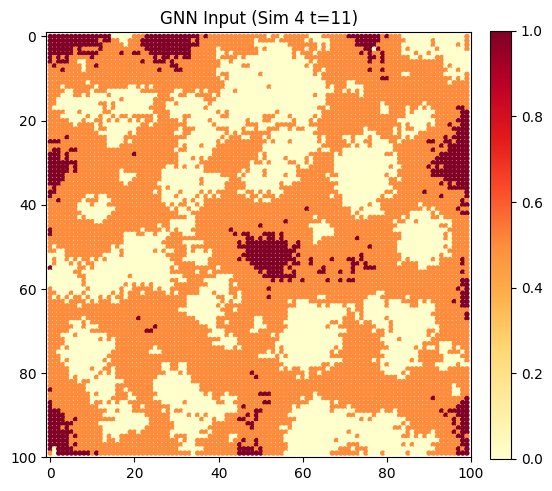

In [16]:
if gnn_data:
    # Pick a random sample
    sample_info = random.choice(gnn_data['samples'])
    
    # Handle path resolution
    file_path = Path("../") / sample_info['file']
    if not file_path.exists():
        file_path = DATA_ROOT / sample_info['file']

    # Load and Parse using imported functions
    data_dict = load_sample(str(file_path))
    gnn_components = get_gnn_data(data_dict)
    
    print(f"   Nodes: {len(gnn_components['nodes'])}")
    print(f"   Edges: {len(gnn_components['edges'])}")
    print(f"   Features Shape: {gnn_components['node_features'].shape}")

    # Plot using the existing _draw_graph function
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # _draw_graph modifies the axes object in-place
    _draw_graph(ax, gnn_components, cmap="YlOrRd")
    
    plt.title(f"GNN Input (Sim {sample_info['sim_id']} t={sample_info['timestep']})")
    plt.show()

The image above shows the full obtained graph as follows: each dot/square on the grid represents a node, the color is associated to the first value in the feature vector (disease level). Since it is a high-scale graph, the edges themselves are not visible. To have a better overview of connectivity, we suggest instead plotting a subgraph.

In [18]:
def get_subgraph(gnn_data, x_max=20, y_max=20):
    """
    Creates a valid GNN dictionary for a subset of the grid.
    Handles node filtering and edge re-indexing automatically.
    """
    nodes = gnn_data['nodes']
    edges = gnn_data['edges']
    features = gnn_data['node_features']
    h, w = gnn_data['shape']

    # 1. Identify Nodes in the Region of Interest (ROI)
    if nodes.ndim == 1:
        ys, xs = np.divmod(nodes, w)
    else:
        xs, ys = nodes[:, 0], nodes[:, 1]
        
    # Create a boolean mask for nodes within the box
    node_mask = (xs < x_max) & (ys < y_max)
    
    # 2. Filter Nodes & Features
    new_nodes = nodes[node_mask]
    new_features = features[node_mask]
    
    # 3. Remap Edges
    full_to_subset_map = np.full(len(nodes), -1)
    full_to_subset_map[node_mask] = np.arange(np.sum(node_mask))
    
    # Find edges where BOTH source and target are in the ROI
    edge_mask = node_mask[edges[:, 0]] & node_mask[edges[:, 1]]
    valid_edges = edges[edge_mask]
    
    # Transform the old indices to the new subset indices
    new_edges = full_to_subset_map[valid_edges]
    
    return {
        "nodes": new_nodes,
        "edges": new_edges,
        "node_features": new_features,
        "shape": (y_max, x_max) # New shape for the plot limits
    }

Original Graph: 10000 nodes
Subgraph:       225 nodes, 420 edges


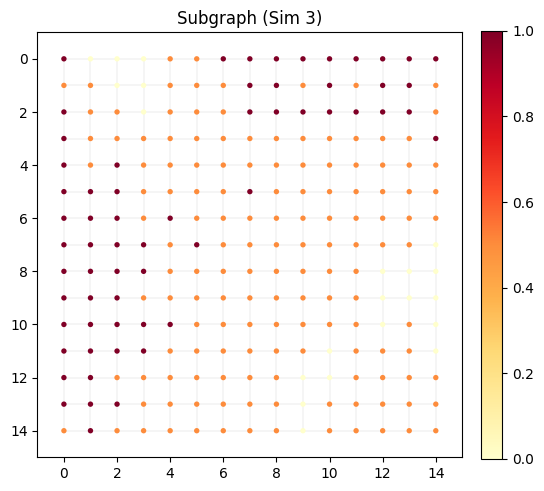

In [19]:
sample_info = random.choice(gnn_data['samples'])
    
    # Handle path resolution
file_path = Path("../") / sample_info['file']
if not file_path.exists():
    file_path = DATA_ROOT / sample_info['file']

    # Load and Parse using imported functions
data_dict = load_sample(str(file_path))
gnn_components = get_gnn_data(data_dict)

subgraph = get_subgraph(gnn_components, x_max=15, y_max=15)

print(f"Original Graph: {len(gnn_components['nodes'])} nodes")
print(f"Subgraph:       {len(subgraph['nodes'])} nodes, {len(subgraph['edges'])} edges")

# 2. Pass it to the EXISTING visualize_dataset function
fig, ax = plt.subplots(figsize=(6, 6))

# This uses the imported function!
_draw_graph(ax, subgraph, cmap="YlOrRd") 

plt.title(f"Subgraph (Sim {sample_info['sim_id']})")
plt.show()